## Question 7

In [1]:
import numpy as np
import cvxpy as cp
from scipy.stats import norm, laplace, uniform
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)
np.set_printoptions(linewidth=np.inf)

### Optimization Problem

The mixture density is clearly linear in $\lambda$. The likelihood function for the estimation of the parameters is <br>
$ \Pi_{i=1}^N \Sigma_{j=1}^k \lambda_j p_j(x_i)$ <br>
This is a product of affine (concave) functions of the parameter, which may not necessarily be concave. To induce concavity, we take the log. Now the log likelihood function becomes <br>
$ \Sigma_{i=1}^N log (\Sigma_{j=1}^k \lambda_j p_j(x_i))$ <br>
Now this is the sum of concave functions (log of affine functions is concave) which is concave. Maximizing the log likelihood is thus a convex optimization problem. It is formulated as <br>
max. $ \Sigma_{i=1}^N log (\Sigma_{j=1}^k \lambda_j p_j(x_i))$ <br>
s.t. $\lambda \geq 0, \Sigma \lambda_i =1$

### Implementation

In [3]:
# True weights for the underlying mixture
true_mixture_weights = [.3, .5, .2]
N = 100
k = 3

In [4]:
# This function generates N from the true mixture of distributions. 
# When you use this function to plot your estimated densities, 
# pass in the weights you obtain instead of the default parameters. 
def generate_samples(mixture_weights):
    np.random.seed(1)
    # Parameters for the distributions in our mixture: N(3, 2^2), U(-1, 2), L(-2, 3)
    samples = np.vstack([[np.random.normal(3, 2), 
                              np.random.uniform(-1, 2), 
                              np.random.laplace(-2, 3)] for _ in range(N)])
    indices = np.random.choice(list(range(len(mixture_weights))), p = mixture_weights, size = N)
    samples = np.take_along_axis(samples, indices[:, None], axis = 1)
    return samples.flatten()

In [5]:
# This function evaluates a set of univariate samples
# under the Gaussian, Uniform, and Laplace densities in the problem.
def evaluate_density(samples):
    # Parameters for the distributions in our mixture: N(3, 2^2), U(-1, 2), L(-2, 3)
    # Minor note: Scipy uniform.pdf expects the first argument as the start interval and the 
    # second as the length of interval, *not* the endpoint
    densities = [[norm.pdf(x, 3,2), 
                          uniform.pdf(x, -1, 3), 
                          laplace.pdf(x, -2, 3)] for x in samples]
    densities = np.array(densities)
    return densities

In [6]:
# This function takes as input the estimated mixture weights
# and generates a plot of both the estimated and true density
# by analytically evaluating the density at each point in a discretized
# interval [-20, 20]
def plot_estimated_and_true_density(estimated_mixture_weights):
    discretized_x = np.linspace(-20, 20, num=100)
    all_densities = evaluate_density(discretized_x)
    estimated_densities = all_densities @ estimated_mixture_weights
    true_densities = all_densities @ true_mixture_weights
    plt.plot(discretized_x, estimated_densities, label = "Estimated")
    plt.plot(discretized_x, true_densities, label = "True")
    plt.title("True vs Estimated Density")
    plt.legend()
    plt.show()

In [7]:
# The below two lines generate the samples and form the densities matrix.
# The densities matrix is of dimension N x k,
# where each row contains the evaluations of a datapoint under each density in the mixture.
samples = generate_samples(true_mixture_weights)
densities = evaluate_density(samples)

In [8]:
# defining variables

lam = cp.Variable(k, nonneg=True)

In [9]:
# defining constraints

cons = [cp.sum(lam) == 1]

In [10]:
# defining objective function

obj = cp.Maximize(cp.sum(cp.log(densities@lam)))

In [11]:
# solving the problem

prob = cp.Problem(obj, cons)
prob.solve();

In [12]:
# optimal values of parameter

lam.value

array([0.296, 0.572, 0.132])

The optimal values of $\lambda$ estimated by the MLE method are pretty close to the true values (0.3, 0.5, 0.2).

We plot the true and estimated mixture densities on the same plot.

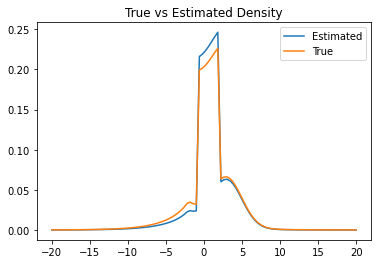

In [13]:
plot_estimated_and_true_density(lam.value)